In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

# 2012 data for future scenarios
df_P_stats = pd.read_csv("P_stats.csv")
df_P= pd.read_csv("P.csv")
df_WS= pd.read_csv("WS.csv")
df_WS_stats= pd.read_csv("WS_stats.csv")
# print(df_P.head())
# check with Matti that it is in UTC timestamp
df_P['time'] = pd.to_datetime(df_P['time'], utc=True) 

df = pd.read_csv("time_series_60min_singleindex.csv")
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], utc=True)
# Input info: HH100 and HH150, 50 MW capacity
# time BFH_LW  Benz_MW  Zary_LW  Uki_MW  Off_NL_HW Fland_NL_MW  DK2_HW  OFF_DK2_HW  
# BFH_LW_1  Benz_MW_1  Zary_LW_1  Uki_MW_1 Off_NL_HW_1  Fland_NL_MW_1  DK2_HW_1  OFF_DK2_HW_1

LCOE 
![image.png](attachment:image.png)

In [3]:
# CAPEX INPUT FROM PAPER: from WISDEM and then multiply by scaling factor according to DEA by 1.296 and according to Cost of Wind Energy review:
# 2017 paper: this would be the approximation that would have been done for a wind farm in that year (by 67.95%) - as that would be how much of the total costs would correspond to the turbine out of all the CAPEX


# 2021 paper: most recent paper: use it as base for future. Assumption of increase or decrease for 2025, 2035 adn 2045 as in paper (by 68,6%)
# from Table A.3 Appendix A, the avg capex in MEur/MW for years 2025, 2035, 2045:
on_CAPEX_fut = [1855000, 1675000, 1540000] # Eur/MW - I have the total MW per year
lifetime= 25 
# ann_on_CAPEX_fut = on_CAPEX_fut/lifetime
ann_on_CAPEX_fut = [capex / lifetime for capex in on_CAPEX_fut]
off_CAPEX_fut = [2, 1.8, 1.8]
# for extreme scenarios i will use the min and max values of CaPex provided
on_VarOPEX = [1.47, 1.40, 1.22] # Eur/MWh - full load hours?
on_FixOPEX= [13720, 12350, 11360] # Eur/MW/yr - I have the total MW per year

Annual_Investment = ann_on_CAPEX_fut[1]/ sum(df_P['Zary_LW_1'])
# sum(df_P['BFH_LW'])
# on_CAPEX_2025= on_CAPEX_fut[1]
inst_cap = 50 #MW
AEP= sum(df_P['Zary_LW_1']*50)
costs= (ann_on_CAPEX_fut[1]*inst_cap + on_FixOPEX[1]*inst_cap)
LCOE_BFH_2025_HH100= costs/ AEP

# positive slope means a decrease in price will happen as deamnd goes to 0 (we can see it proved in the graph)
# # with std. p: p = mD + (1- m) -mQ'

Max_Pow_Out= 50*8760
CF= AEP/Max_Pow_Out
CF
LCOE_BFH_2025_HH100


27.453508080880415

COVE

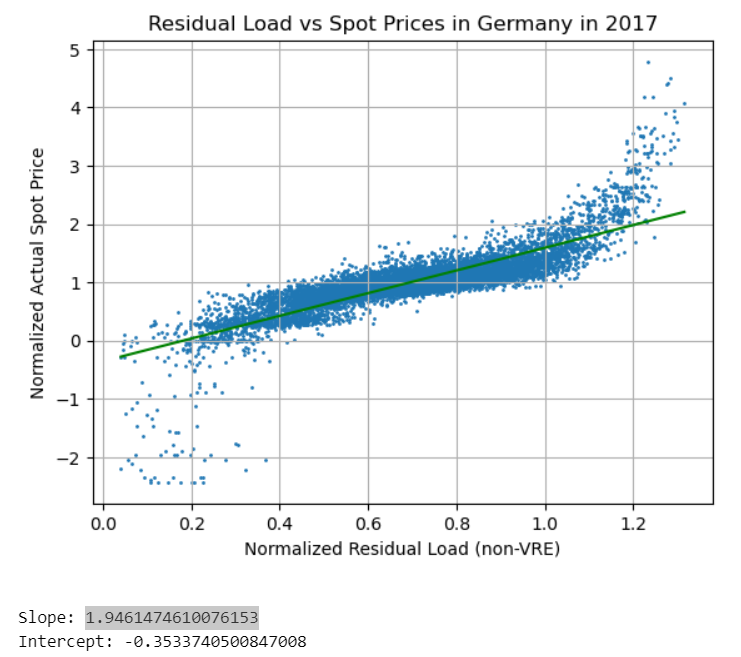

In [5]:

def filter_on_year(df: pd.DataFrame, year: int):
    """This functions filters a dataframe on a year using the utc_timestamp column.

    Args:
        year (int): year e.g. 2017
    Return:
        df: a dataframe filter on the year parameter
    """
    return df[df['utc_timestamp'].dt.year == year]

def vre_share(df_vre: pd.DataFrame, country: str = "DE", year_vre: int = 2017):
    """it calculates the VRE for a country.

    Args:
        df (pd.DataFrame): df filtered on a year.
        country (str, optional): country code for dataframe column. Defaults to "DE".
        year_vre (int): the year for the vre

    Returns:
        _type_: _description_
    """
    # GERMANTY 2017: base example
    df_vre = filter_on_year(df=df_vre, year=year_vre)
    x=df_vre['utc_timestamp']
    y1 =df_vre[f"{country}_wind_offshore_generation_actual"]
    y2 =df_vre[f"{country}_wind_onshore_generation_actual"]
    y3 =df_vre[f"{country}_solar_generation_actual"]

    VRE_sum = y1+y2+y3
    arr_VRE_sum_avg = np.full_like(VRE_sum, VRE_sum.mean())
    # arr_VRE_sum_avg[17545:26305+1] = VRE_sum_avg
    y4 = arr_VRE_sum_avg
    
    # plt.stackplot(x, y1, y2, y3, labels=['Off', 'On', 'Sol'])
    # plt.title(f'VRE generation in {country} in {year_vre}')
    # plt.xlabel('Time[h]')
    # plt.ylabel('Power [MW]')
    # plt.legend(loc='upper left')
    # plt.show()
    
    # plt.plot(x, y4, label = "Qavg")
    # plt.plot(x, VRE_sum)
    # plt.title(f'VRE generation in {country} in {year_vre}')
    # plt.xlabel('Time[h]')
    # plt.ylabel('Power [MW]')
    # plt.legend(loc='upper left')
    # plt.show()
    
    Q_p= VRE_sum-arr_VRE_sum_avg
    print(Q_p)
    # VRE_sum = pd.Series(y1) + pd.Series(y2) + pd.Series(y3)
    
    return VRE_sum #, VRE_sum_avg #if i put the ys, it returns a list

# for year in range(2017,2018):
year = 2017
VRE_sum_de = vre_share(df_vre=df, country= "DE", year_vre=year)
# Q_p_de2017=vre_share() should include in input smth?

# Normalized vre for the demand
def normalized_vre(vre):
    """normalizes the VRE generation with max"""
    return vre / np.max(vre)

# def normalized_spot(df_spot: pd.DataFrame):
#     """normalizes with mean"""
#     sp=df_spot["Day Ahead Auction"].drop(0)
#     return sp/sp.mean()

VRE_sum_de_norm = normalized_vre(VRE_sum_de)
# VRE_sum_dk_2_norm = normalized_vre(VRE_sum_dk_2)

# df_SPL_normalized = normalized_spot(df_SPL)

m_2017= 1.946147
# m_2017= 0
p_DE_2017= m_2017*VRE_sum_de_norm +(1-m_2017) 
# p_DE_2017= m_2017*VRE_sum_de_norm +(1-m_2017) - m_2017*Q_p

COVE_BFH_2025_HH100= (costs*p_DE_2017)/ AEP
COVE_BFH_2025_HH100
p_DE_2017
# VRE_sum_de_norm

17545     -453.652283
17546     -736.652283
17547    -1085.652283
17548     -951.652283
17549     -563.652283
             ...     
26300    13940.347717
26301    14171.347717
26302    14538.347717
26303    14777.347717
26304    15760.347717
Length: 8760, dtype: float64


17545   -0.370376
17546   -0.380982
17547   -0.394062
17548   -0.389040
17549   -0.374498
           ...   
26300    0.169080
26301    0.177737
26302    0.191492
26303    0.200449
26304    0.237289
Length: 8760, dtype: float64

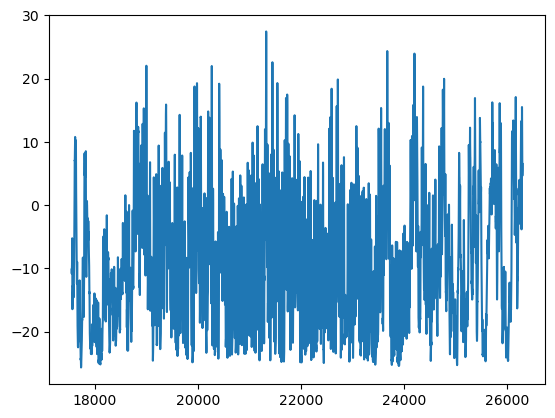

In [6]:
COVE_tot= sum(COVE_BFH_2025_HH100)
plt.plot(COVE_BFH_2025_HH100.index, COVE_BFH_2025_HH100)
plt.show()
COVE_BFH_2017_2025_HH100= COVE_tot/8760
# COVE_BFH_2017_2025_HH100= COVE_tot

In [7]:
print('LCOE is {}'.format(LCOE_BFH_2025_HH100))
print('COVE is {}'.format(COVE_BFH_2017_2025_HH100))

LCOE is 27.453508080880415
COVE is -9.701348538248975
